# NetCDF handling

NetCDF formatted files are much faster to read and write for large datasets. In order to make the most of this, the `ScmRun` objects have the ability to read and write netCDF files.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback
from glob import glob

import numpy as np
import seaborn as sns
import xarray as xr

from scmdata.run import ScmRun, run_append
from scmdata.netcdf import nc_to_run

## Helper bits and piecs

In [2]:
OUT_FNAME = "/tmp/out_runs.nc"

In [3]:
def new_timeseries(
    n=100,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = run_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            unit=["K", "ppm", "W/m^2"],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs.metadata["source"] = "fake data"
runs

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119      K             Surface Temperature
	1   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       0   ssp119  W/m^2               Radiative Forcing
	3   example  World       1   ssp119      K             Surface Temperature
	4   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       1   ssp119  W/m^2               Radiative Forcing
	6   example  World       2   ssp119      K             Surface Temperature
	7   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       2   ssp119  W/m^2               Radiative Forcing
	9   example  World       3   ssp119      K             Surface Temperature
	10  example  World       3   ssp119    ppm  At

## Reading/Writing to NetCDF4

### Basics

Writing the runs to disk is easy. The one trick is that each variable and dimension combination must have unique metadata. If they do not, you will receive an error message like the below.

In [5]:
try:
    runs.to_nc(OUT_FNAME, dimensions=["region"])
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: ['region'] dimensions are not unique for variable Atmospheric Concentrations|CO2


In our dataset, there is more than one "run_id" per variable hence we need to use a different dimension, `run_id`, because this will result in each variable's remaining metadata being unique.

In [6]:
runs.to_nc(OUT_FNAME, dimensions=["run_id"])

The output netCDF file can be read using the `from_nc` method, `nc_to_run` function or directly using `xarray`.

In [7]:
# NBVAL_IGNORE_OUTPUT
runs_netcdf = ScmRun.from_nc(OUT_FNAME)
runs_netcdf

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	1   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	3   example  World       3   ssp119    ppm  Atmospheric Concentrations|CO2
	4   example  World       4   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       5   ssp119    ppm  Atmospheric Concentrations|CO2
	6   example  World       6   ssp119    ppm  Atmospheric Concentrations|CO2
	7   example  World       7   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       8   ssp119    ppm  Atmospheric Concentrations|CO2
	9   example  World       9   ssp119    ppm  Atmospheric Concentrations|CO2
	10  example  World       0   ssp119  W/m^2    

In [8]:
# NBVAL_IGNORE_OUTPUT
nc_to_run(ScmRun, OUT_FNAME)

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	1   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	3   example  World       3   ssp119    ppm  Atmospheric Concentrations|CO2
	4   example  World       4   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       5   ssp119    ppm  Atmospheric Concentrations|CO2
	6   example  World       6   ssp119    ppm  Atmospheric Concentrations|CO2
	7   example  World       7   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       8   ssp119    ppm  Atmospheric Concentrations|CO2
	9   example  World       9   ssp119    ppm  Atmospheric Concentrations|CO2
	10  example  World       0   ssp119  W/m^2    

In [9]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset(OUT_FNAME)

<xarray.Dataset>
Dimensions:                          (run_id: 10, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Atmospheric_Concentrations__CO2  (run_id, time) float64 0.0 0.2137 ... 70.05
    Radiative_Forcing                (run_id, time) float64 0.0 0.4639 ... 61.69
    Surface_Temperature              (run_id, time) float64 0.0 0.5842 ... 77.84
Attributes:
    created_at:        2020-09-11T06:51:03.315485
    _scmdata_version:  0.6.4+91.gdbc453b.dirty
    source:            fake data

The additional `metadata` in `runs` is also serialized and deserialized in the netCDF files. The `metadata` of the loaded `ScmRun` will also contain some additional fields about the file creation.

In [10]:
# NBVAL_IGNORE_OUTPUT
assert "source" in runs_netcdf.metadata
runs_netcdf.metadata

{'created_at': '2020-09-11T06:51:03.315485',
 '_scmdata_version': '0.6.4+91.gdbc453b.dirty',
 'source': 'fake data'}

### Splitting your data

Sometimes if you have complicated ensemble runs it might be more efficient to split the data into smaller subsets.

In the below example we iterate over scenarios to produce a netCDF file per scenario.

In [11]:
large_run = []

# 10 runs for each scenario
for sce in ["ssp119", "ssp370", "ssp585"]:
    large_run.extend(
        [
            new_timeseries(
                count=3,
                scenario=sce,
                variable=[
                    "Surface Temperature",
                    "Atmospheric Concentrations|CO2",
                    "Radiative Forcing",
                ],
                unit=["K", "ppm", "W/m^2"],
                paraset_id=paraset_id,
            )
            for paraset_id in range(10)
        ]
    )

large_run = run_append(large_run)

# also set a run_id (often we'd have paraset_id and run_id,
# one which keeps track of the parameter set we've run and
# the other which keeps track of the run in a large ensemble)
large_run["run_id"] = large_run.meta.index.values
large_run

<scmdata.ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model  paraset_id region  run_id scenario   unit  \
	0   example           0  World       0   ssp119      K   
	1   example           0  World       1   ssp119    ppm   
	2   example           0  World       2   ssp119  W/m^2   
	3   example           1  World       3   ssp119      K   
	4   example           1  World       4   ssp119    ppm   
	..      ...         ...    ...     ...      ...    ...   
	85  example           8  World      85   ssp585    ppm   
	86  example           8  World      86   ssp585  W/m^2   
	87  example           9  World      87   ssp585      K   
	88  example           9  World      88   ssp585    ppm   
	89  example           9  World      89   ssp585  W/m^2   
	
	                          variable  
	0              Surface Temperature  
	1   Atmospheric Concentrations|CO2  
	2                Radiative Forcing  
	3              Surfa

For such a data set, since both `run_id` and `paraset_id` vary, both could be added as dimensions in the file.

The one problem with this approach is that you get very sparse arrays because the data is written on a 100 x 30 x 90 (time points x paraset_id x run_id) grid but there's only 90 timeseries so you end up with 180 timeseries worth of nans (although this is a relatively small problem because the netCDF files use compression to minismise the impact of the extra nan values).

In [12]:
for sce_df in large_run.groupby("scenario"):
    sce = sce_df.get_unique_meta("scenario", True)
    sce_df.to_nc(
        "/tmp/out-{}-sparse.nc".format(sce),
        dimensions=["run_id", "paraset_id"],
    )

In [13]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset("/tmp/out-ssp585-sparse.nc")

<xarray.Dataset>
Dimensions:                          (paraset_id: 10, run_id: 30, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 60 61 62 63 ... 86 87 88 89
  * paraset_id                       (paraset_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Atmospheric_Concentrations__CO2  (run_id, paraset_id, time) float64 nan ....
    Radiative_Forcing                (run_id, paraset_id, time) float64 nan ....
    Surface_Temperature              (run_id, paraset_id, time) float64 0.0 ....
Attributes:
    created_at:        2020-09-11T06:51:03.640806
    _scmdata_version:  0.6.4+91.gdbc453b.dirty

Data for each scenario can then be loaded independently instead of having to load all the data and then filtering

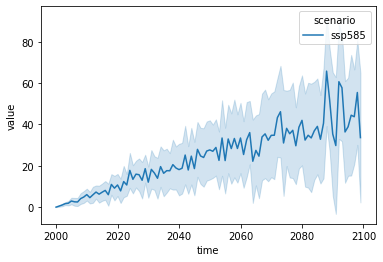

In [14]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc("/tmp/out-ssp585-sparse.nc").filter(
    "Surface Temperature"
).line_plot()

In [15]:
# NBVAL_IGNORE_OUTPUT
# Load all scenarios
run_append([ScmRun.from_nc(fname) for fname in glob("/tmp/out-*-sparse.nc")])

<scmdata.ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model  paraset_id region  run_id scenario unit  \
	0   example           0  World      31   ssp370  ppm   
	1   example           1  World      34   ssp370  ppm   
	2   example           2  World      37   ssp370  ppm   
	3   example           3  World      40   ssp370  ppm   
	4   example           4  World      43   ssp370  ppm   
	..      ...         ...    ...     ...      ...  ...   
	85  example           5  World      75   ssp585    K   
	86  example           6  World      78   ssp585    K   
	87  example           7  World      81   ssp585    K   
	88  example           8  World      84   ssp585    K   
	89  example           9  World      87   ssp585    K   
	
	                          variable  
	0   Atmospheric Concentrations|CO2  
	1   Atmospheric Concentrations|CO2  
	2   Atmospheric Concentrations|CO2  
	3   Atmospheric Concentrations|CO2  
	4   At

An alternative to the sparse arrays is to specify the variables in the `extras` attribute. This adds the metadata to the netCDF file as an additional variable with the same dimensions as the data (except for `time` for obvious reasons).

In [16]:
for sce_df in large_run.groupby("scenario"):
    sce = sce_df.get_unique_meta("scenario", True)
    sce_df.to_nc(
        "/tmp/out-{}-extras.nc".format(sce),
        dimensions=["run_id"],
        extras=["paraset_id"],
    )

In [17]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset("/tmp/out-ssp585-extras.nc")

<xarray.Dataset>
Dimensions:                          (run_id: 30, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 60 61 62 63 ... 86 87 88 89
Data variables:
    paraset_id                       (run_id) int64 0 0 0 1 1 1 ... 8 8 8 9 9 9
    Atmospheric_Concentrations__CO2  (run_id, time) float64 nan nan ... nan nan
    Radiative_Forcing                (run_id, time) float64 nan nan ... 34.57
    Surface_Temperature              (run_id, time) float64 0.0 0.5128 ... nan
Attributes:
    created_at:        2020-09-11T06:51:03.997462
    _scmdata_version:  0.6.4+91.gdbc453b.dirty

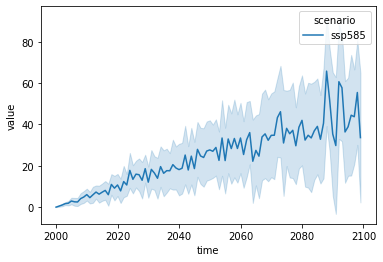

In [18]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc("/tmp/out-ssp585-extras.nc").filter(
    "Surface Temperature"
).line_plot()

### Multi-dimensional data

**scmdata** can also handle having more than one dimension. This can be especially helpful if you have output from a number of models (IAMs), scenarios, regions and runs.

In [19]:
multi_dimensional_run = []

for model in ["AIM", "GCAM", "MESSAGE", "REMIND"]:
    for sce in ["ssp119", "ssp370", "ssp585"]:
        for region in ["World", "R5LAM", "R5MAF", "R5ASIA", "R5OECD", "R5REF"]:
            multi_dimensional_run.extend(
                [
                    new_timeseries(
                        count=3,
                        model=model,
                        scenario=sce,
                        region=region,
                        variable=[
                            "Surface Temperature",
                            "Atmospheric Concentrations|CO2",
                            "Radiative Forcing",
                        ],
                        unit=["K", "ppm", "W/m^2"],
                        paraset_id=paraset_id,
                    )
                    for paraset_id in range(10)
                ]
            )

multi_dimensional_run = run_append(multi_dimensional_run)

multi_dimensional_run

<scmdata.ScmRun (timeseries: 2160, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	       model  paraset_id region scenario   unit  \
	0        AIM           0  World   ssp119      K   
	1        AIM           0  World   ssp119    ppm   
	2        AIM           0  World   ssp119  W/m^2   
	3        AIM           1  World   ssp119      K   
	4        AIM           1  World   ssp119    ppm   
	...      ...         ...    ...      ...    ...   
	2155  REMIND           8  R5REF   ssp585    ppm   
	2156  REMIND           8  R5REF   ssp585  W/m^2   
	2157  REMIND           9  R5REF   ssp585      K   
	2158  REMIND           9  R5REF   ssp585    ppm   
	2159  REMIND           9  R5REF   ssp585  W/m^2   
	
	                            variable  
	0                Surface Temperature  
	1     Atmospheric Concentrations|CO2  
	2                  Radiative Forcing  
	3                Surface Temperature  
	4     Atmospheric Concentrations|CO2  
	...           

In [20]:
multi_dim_outfile = "/tmp/out-multi-dimensional.nc"

In [21]:
multi_dimensional_run.to_nc(
    multi_dim_outfile,
    dimensions=("region", "model", "scenario", "paraset_id"),
)

In [22]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset(multi_dim_outfile)

<xarray.Dataset>
Dimensions:                          (model: 4, paraset_id: 10, region: 6, scenario: 3, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * region                           (region) object 'R5ASIA' ... 'World'
  * model                            (model) object 'AIM' 'GCAM' ... 'REMIND'
  * scenario                         (scenario) object 'ssp119' ... 'ssp585'
  * paraset_id                       (paraset_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Atmospheric_Concentrations__CO2  (region, model, scenario, paraset_id, time) float64 ...
    Radiative_Forcing                (region, model, scenario, paraset_id, time) float64 ...
    Surface_Temperature              (region, model, scenario, paraset_id, time) float64 ...
Attributes:
    created_at:        2020-09-11T06:51:07.950400
    _scmdata_version:  0.6.4+91.gdbc453b.dirty

In [23]:
# NBVAL_IGNORE_OUTPUT
multi_dim_loaded_co2_conc = ScmRun.from_nc(multi_dim_outfile).filter(
    "Atmospheric Concentrations|CO2"
)

seaborn_df = multi_dim_loaded_co2_conc.long_data()
seaborn_df.head()

,model,paraset_id,region,scenario,unit,variable,time,value
0,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2000-01-01,0.000000
1,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2001-01-01,0.115663
2,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2002-01-01,1.993963
3,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2003-01-01,0.545859
4,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2004-01-01,1.173638


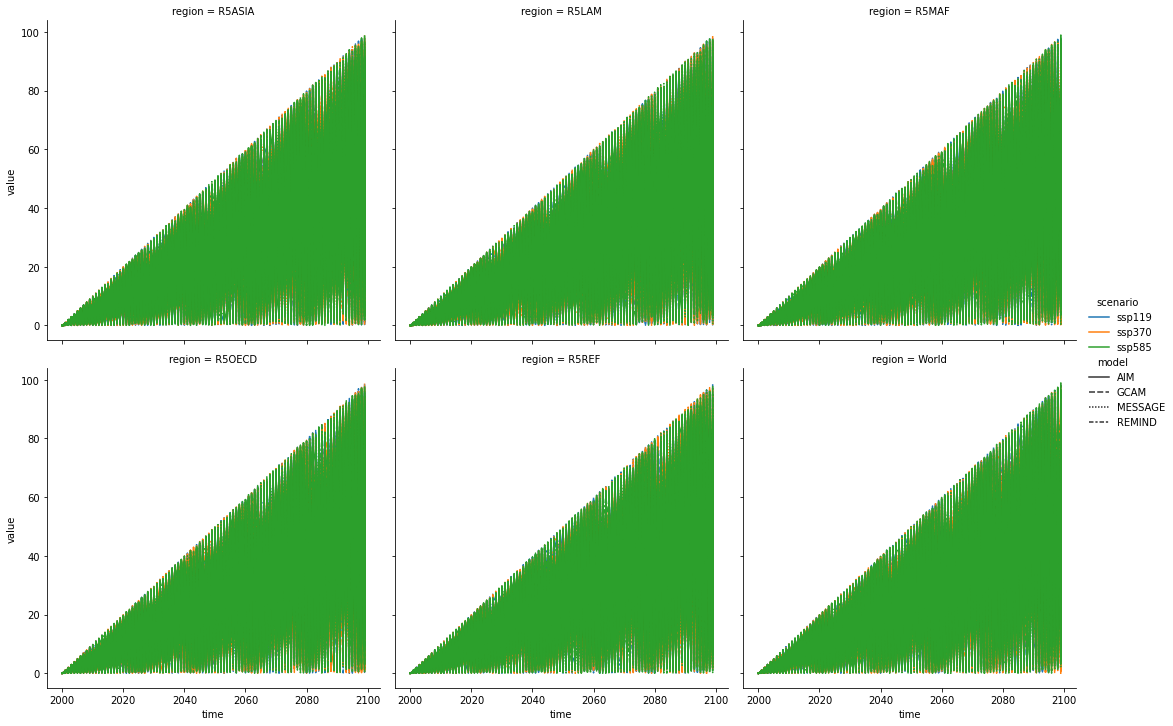

In [24]:
# NBVAL_IGNORE_OUTPUT
sns.relplot(
    data=seaborn_df,
    x="time",
    y="value",
    units="paraset_id",
    estimator=None,
    hue="scenario",
    style="model",
    col="region",
    col_wrap=3,
    kind="line",
)